# First Run of Data Exploration

In this notebook I will be:
1. creating the functionality to open the raw data
2. filtering for clinical trial results
3. read through a few of the results and taking notes on what I do, and if possible, what I do not see

## Table of Contents

1. [Importing Modules and Libraries](#1)
2. [Opening the Raw Data](#2)
3. [Data Cleaning](#3)
4. [Filter for Keywords](#4)
5. [Data Exploration](#5)

# Introduction

In this data exploration, we will be focussing on finding articles that declare clinical trial results. This is a pivotal event type for these types of companies and so it would make sense that this would have a large affect on the stock prices.

There are definitely going to be some issues with the data collected such as:
* Survivorship bias:
    * If a company has, for example, only one drug in their pipeline and that drug fails the clinical trials, then that company will likely go bankrupt and be removed from the market. 
    * Similarily, if a company passes or fails, their stock price could have moved them out of our Market Cap. range
    
* Local time:
    * The articles collected are largely only for recent times. Most of the data is within the past 3 years, so will be missing out on larger macro effects

---

## June 29, 2019

## Importing Modules and Libraries for Exploration
<a id="1"></a>

In [98]:
# Imports

# Numerical Libraries
import numpy as np
import pandas as pd

# Visual Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Local Libraries
import sys
sys.path.append("../../src/data/")
from make_dataset import clean_and_open_busines_wire_data_01

sys.path.append("../../src/features")
from text_cleaning import remove_non_english_articles
from general_helper_functions import GetPrices

In [130]:
# Settings

# Stop the warnings for chain in pandas...
pd.options.mode.chained_assignment = None

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Opening the Raw Data
<a id="2"></a>

Using the function from src, open the 3 datasets that have so far been collected.

This opening section will be condensed into a function and placed into the make_dataset module and the converted data will be put into the data/interim folder.

In [3]:
business_wire_raw, watchlist_raw, stock_prices_raw = get_raw_data()

Let's take a quick look to ensure that everything loaded properly

In [4]:
business_wire_raw.head()

,link,time,title,ticker,article
0,http://www.businesswire.com/news/home/20190604...,"June 04, 2019",ACADIA Pharmaceuticals to Present at the Goldm...,ACAD,SAN DIEGO--(BUSINESS WIRE)--ACADIA Pharmaceut...
1,http://www.businesswire.com/news/home/20190518...,"May 18, 2019",ACADIA Pharmaceuticals to Present Phase 2 CLAR...,ACAD,SAN DIEGO--(BUSINESS WIRE)--ACADIA Pharmaceut...
2,http://www.businesswire.com/news/home/20190515...,"May 15, 2019",Fastest Growing Companies/Startups in San Fran...,ACAD,"BOULDER, Colo.--(BUSINESS WIRE)--Growjo annou..."
3,http://www.businesswire.com/news/home/20190507...,"May 07, 2019",ACADIA Pharmaceuticals to Present at the Bank ...,ACAD,SAN DIEGO--(BUSINESS WIRE)--ACADIA Pharmaceut...
4,http://www.businesswire.com/news/home/20190502...,"May 02, 2019","Alzheimer's Disease: Pipeline Review, Develope...",ACAD,"DUBLIN--(BUSINESS WIRE)--The ""Alzheimer's Dis..."


In [5]:
watchlist_raw.head()

,Ticker,Market Cap,Sector,Exchange
Company Name,,,,
Abeona Therapeutics Inc.,ABEO,310.20,Medical,NSDQ
"ARCA biopharma, Inc.",ABIO,6.37,Medical,NSDQ
"ABIOMED, Inc.",ABMD,15897.32,Medical,NSDQ
Arbutus Biopharma Corporation,ABUS,210.26,Medical,NSDQ
ACADIA Pharmaceuticals Inc.,ACAD,2867.97,Medical,NSDQ


In [6]:
stock_prices_raw.head()

,OMER,VRAY,ICPT,AUTL,AXGN,PDLI,HZNP,ASMB,SGRY,ANAB,...,PBYI,WVE,ENDP,VREX,RDNT,HSKA,RETA,XON,TCMD,ARNA
2009-10-08,8.73,NaN,NaN,NaN,3.58,3.2020,NaN,NaN,NaN,NaN,...,NaN,NaN,23.95,NaN,2.90,4.2749,NaN,NaN,NaN,41.6
2009-10-09,8.46,NaN,NaN,NaN,3.62,3.2833,NaN,NaN,NaN,NaN,...,NaN,NaN,23.82,NaN,3.06,4.5664,NaN,NaN,NaN,42.1
2009-10-12,8.41,NaN,NaN,NaN,3.53,3.2910,NaN,NaN,NaN,NaN,...,NaN,NaN,23.97,NaN,3.24,4.2749,NaN,NaN,NaN,40.8
2009-10-13,7.47,NaN,NaN,NaN,3.62,3.3569,NaN,NaN,NaN,NaN,...,NaN,NaN,23.83,NaN,3.18,4.2701,NaN,NaN,NaN,41.3
2009-10-14,7.44,NaN,NaN,NaN,3.79,3.4343,NaN,NaN,NaN,NaN,...,NaN,NaN,23.88,NaN,3.20,4.1778,NaN,NaN,NaN,41.5


---

## Data Cleaning
<a id="3"></a>

### Business Wire Articles

From previous explorations on the data set, I know that there are a few issues pertaining to the business wire article data.

1. There are a couple articles listed as NaN, these samples will need to be removed.
2. Some of the data are in foreign languages, these samples will need to be removed.
3. To make searching easier, I will convert the text into all lower case.
4. Further for this exploration we will not need to keep the "link" feature

### Watchlist

While scraping for the Business Wire Articles I only scraped for companies within a certain bound w.r.t. Market Capitalization. To clean this and ensure we keep the companies that were scraped (with no errors), I will take the unique tickers and filter the Watchlist. Also I will rename the columns to fit with the other data frames.

### Stock Prices
To reduce the number of entries, making it easier for searching later, I will reduce this data set to only the companies in our unique list. Further, the stock prices are not sorted by date, so they need to be sorted as well.

In [39]:
# Business Wire Articles

# 0: Create a copy of the data
clinical_trial_df = business_wire_raw.copy()
print("Original size: ", clinical_trial_df.shape)

# 1: Remove NaN
clinical_trial_df.dropna(inplace=True)
print("Size after removing NaN: ", clinical_trial_df.shape)

# 2: Remove non-English articles
clinical_trial_df = remove_non_english_articles(clinical_trial_df)
print("Size after removing non-English articles: ", clinical_trial_df.shape)

# 3: Set all strings to lower case in "title" and "article" columns
clinical_trial_df.article = clinical_trial_df.article.apply(str.lower)
clinical_trial_df.title = clinical_trial_df.title.apply(str.lower)

# 4: Drop "link" column
clinical_trial_df.drop("link", inplace=True, axis=1)

# 5: Ensure date is a datetime object
clinical_trial_df.time = pd.to_datetime(clinical_trial_df.time)

clinical_trial_df.head()

Original size:  (8806, 5)
Size after removing NaN:  (8802, 5)
Size after removing non-English articles:  (8434, 5)


,time,title,ticker,article
0,2019-06-04,acadia pharmaceuticals to present at the goldm...,ACAD,san diego--(business wire)--acadia pharmaceut...
1,2019-05-18,acadia pharmaceuticals to present phase 2 clar...,ACAD,san diego--(business wire)--acadia pharmaceut...
2,2019-05-15,fastest growing companies/startups in san fran...,ACAD,"boulder, colo.--(business wire)--growjo annou..."
3,2019-05-07,acadia pharmaceuticals to present at the bank ...,ACAD,san diego--(business wire)--acadia pharmaceut...
4,2019-05-02,"alzheimer's disease: pipeline review, develope...",ACAD,"dublin--(business wire)--the ""alzheimer's dis..."


In [8]:
# Watchlist

# 0: Create a copy of the data
watchlist_df = watchlist_raw.copy()
print("Original size: ", watchlist_df.shape)

# 1: Get a list of the unique companies that have scraped article data
unique_companies = clinical_trial_df.ticker.unique()

# 2: Keep only the companies from the list
watchlist_df = watchlist_df.loc[watchlist_df.Ticker.isin(unique_companies)]
print("Final size: ", watchlist_df.shape)

watchlist_df.columns = ["ticker", "marketcap", "sector", "exchange"]

watchlist_df.head()

Original size:  (721, 4)
Final size:  (197, 4)


,ticker,marketcap,sector,exchange
Company Name,,,,
ACADIA Pharmaceuticals Inc.,ACAD,2867.97,Medical,NSDQ
"Acadia Healthcare Company, Inc.",ACHC,2444.69,Medical,NSDQ
"Acorda Therapeutics, Inc.",ACOR,614.92,Medical,NSDQ
Addus HomeCare Corporation,ADUS,908.35,Medical,NSDQ
"Aerie Pharmaceuticals, Inc.",AERI,1819.98,Medical,NSDQ


Wow, that is a lot of companies that wer dropped. I may have to go back and take a look at the data to see if this makes sense or not. Recall that I only scraped for a selected Market Cap. size.

In [56]:
# 0: Make a copy of the stock prices here
prices_df = stock_prices_raw.copy()
print("Original size: ", prices_df.shape)

# 1: Reduce the new copy of prices to only the companies under our scope
prices_df = prices_df[unique_companies]
print("Final size: ", prices_df.shape)

# 2: Sort by date
prices_df.sort_index(inplace=True)

# 3: Ensure index is datetime object
prices_df.index = pd.to_datetime(prices_df.index)

prices_df.tail()

Original size:  (5402, 208)
Final size:  (5402, 197)


,ACAD,ACHC,ACOR,ADUS,AERI,AGIO,AIMT,AKCA,AKRX,ALDR,...,VRAY,VREX,WMGI,WVE,XENT,XLRN,XNCR,XON,YI,ZGNX
2019-06-17,25.42,34.00,7.68,72.56,33.29,50.66,20.54,24.39,4.34,12.45,...,8.95,28.21,31.31,27.43,24.45,38.36,32.55,7.60,6.75,40.30
2019-06-18,25.93,34.20,7.66,72.92,33.84,51.91,20.20,23.98,4.48,11.73,...,9.13,28.95,31.69,27.92,23.97,40.62,34.54,8.60,6.62,39.79
2019-06-19,26.62,34.04,7.54,75.89,32.89,51.42,20.07,22.80,4.65,11.55,...,9.11,29.26,31.88,26.93,24.16,39.92,34.65,8.55,6.62,40.37
2019-06-20,25.73,34.52,7.28,74.91,32.13,51.30,20.24,22.90,4.74,11.54,...,8.92,29.57,30.48,26.86,23.62,40.85,35.10,8.01,6.62,40.91
2019-06-21,26.00,34.72,7.49,74.63,30.91,50.78,20.00,24.26,4.78,11.60,...,8.72,29.21,30.09,26.18,23.15,40.18,35.16,7.57,6.49,40.62


---

## Filter for Keywords
<a id="4"></a>

### "Clinical" in the Article

In [57]:
df_filtered_for_clinical = clinical_trial_df.loc[clinical_trial_df.article.str.contains("clinical")]
print("Filtered size: ", df_filtered_for_clinical.shape)

Filtered size:  (4518, 4)


So now there are about half the number of articles. Let's take a quick look at some of them.

In [41]:
# Create a function that will help display the article with it's meta-data
def display_text(article_row, article_sample_size=300):
    watchlist_row = watchlist_df.loc[watchlist_df.ticker == article_row.ticker]
    
    line_1 = "{} - {} - {}".format(watchlist_row.index.values[0], article_row.ticker, article_row.time)
    line_2 = article_row.title
    line_3 = article_row.article[:article_sample_size]
    line_4 = "-" * 30
    line_5 = "\n"
    
    return "\n\n".join([line_1, line_2, line_3, line_4, line_5])

In [12]:
sample_df = df_filtered_for_clinical.sample(20)

In [17]:
for _, row in sample_df.iterrows():
    print(display_text(row))

Arrowhead Pharmaceuticals, Inc. - ARWR - January 07, 2019

arrowhead pharmaceuticals begins dosing in phase 1 study of aro-ang3 for treatment of dyslipidemias and metabolic diseases

 pasadena, calif.--(business wire)--arrowhead pharmaceuticals inc. (nasdaq: arwr) today announced that it has dosed the first subjects in a phase 1 clinical study of aro-ang3, an rnai-based investigational medicine targeting angiopoietin like protein 3 (angptl3) being developed for the treatment of 

------------------------------



WAVE Life Sciences Ltd. - WVE - July 17, 2017

wave life sciences initiates two phase 1b/2a clinical trials: precision-hd1 and precision-hd2 in patients with huntington’s disease

 cambridge, mass.--(business wire)--wave life sciences ltd. (nasdaq:wve), a biotechnology company focused on delivering transformational therapies for patients with serious, genetically-defined diseases, today announced the initiation of the company’s precision-hd program, which includes precision-h


Not very fruitful; There are a large number of articles left which doesn't seem realistic if we are simply looking for clinical trial results. Further from reading  a few of the articles, most infact aren't about clinical trials at all.

But scanning through, perhaps instead we could search the title for "phase". 

### "Phase" in the Title

In [58]:
df_filtered_for_phase = clinical_trial_df.loc[clinical_trial_df.title.str.contains("phase")]
print("Filtered size: ", df_filtered_for_phase.shape)

Filtered size:  (226, 4)


In [21]:
sample_df = df_filtered_for_phase.sample(20)

for _, row in sample_df.iterrows():
    print(display_text(row))

Aimmune Therapeutics, Inc. - AIMT - June 04, 2019

new data from phase 3 palisade follow-on study of ar101 for peanut allergy show continued immunomodulation through daily dosing beyond one year

 lisbon, portugal--(business wire)--aimmune therapeutics, inc. (nasdaq: aimt), a biopharmaceutical company developing treatments for life-threatening food allergies, today announced results from arc004, an open-label, rollover study of the landmark phase 3 palisade trial, which showed that extending

------------------------------



China Biologic Products, Inc. - CBPO - May 20, 2019

chimeric antigen receptor cell therapy report, 2019 - overview of the approved and late-stage pipeline car cell therapy landscape (pre-clinical and phase i car-nk cells) - researchandmarkets.com

 dublin--(business wire)--the "chimeric antigen receptor cell therapy" report has been added to researchandmarkets.com's offering. the "chimeric antigen receptor cell therapy", report provides an overview of the approve

## June 30, 2019

Presumably we now have 226 articles that are related to a phase of clinical trials. Let's try a few other filters as well.

Other keywords to use:
* trial
* result (Note: this will give results that are outside of our current scope such as financial results)
* pipeline (this will give pipeline reviews, which could also be beneficial and relevant)

In [28]:
df_filtered_for_trial = clinical_trial_df.loc[clinical_trial_df.title.str.contains("trial")]
print("Filtered size for trial filter: ", df_filtered_for_trial.shape)

df_filtered_for_result = clinical_trial_df.loc[clinical_trial_df.title.str.contains("result")]
print("Filtered size for result filter: ", df_filtered_for_result.shape)

df_filtered_for_pipeline = clinical_trial_df.loc[clinical_trial_df.title.str.contains("pipeline")]
print("Filtered size for pipeline filter: ", df_filtered_for_pipeline.shape)

Filtered size for trial filter:  (292, 4)
Filtered size for result filter:  (720, 4)
Filtered size for pipeline filter:  (1368, 4)


Let's simply take a look at the titles for these as I think the main information for filtering will be contained there anyway:

In [29]:
print("Filtered for TRIAL")
for _, row in df_filtered_for_trial.sample(10).iterrows():
    print(row.ticker)
    print(row.title)
    print("-"*30)
    print("\n")
    
print("\n\n")

print("Filtered for RESULT")
for _, row in df_filtered_for_result.sample(10).iterrows():
    print(row.ticker)
    print(row.title)
    print("-"*30)
    print("\n")
    
print("\n\n")

print("Filtered for PIPELINE")
for _, row in df_filtered_for_pipeline.sample(10).iterrows():
    print(row.ticker)
    print(row.title)
    print("-"*30)
    print("\n")
    
print("\n\n")

Filtered for TRIAL
APLS
hemoglobinuria global clinical trials review - h2, 2017 - research and markets
------------------------------


ATRC
atricure announces completion of patient enrollment in the converge ide clinical trial
------------------------------


BCRX
angioedema global clinical trials review 2016 - key players are shire, halozyme therapeutics & atlantic research group - research and markets
------------------------------


RGNX
mucopolysaccharidosis i (hurler syndrome) pipeline analysis 2018 (h1) - focusing on clinical trials and results, drug profiling, patents, collaborations, and other recent developments - researchandmarkets.com
------------------------------


ATRC
global atrial fibrillation technologies and markets report, 2017-2023 with profiles of abbott lab, aegis medical innovations, boston scientific, ge, johnson & johnson, medtronic and philips - researchandmarkets.com
------------------------------


ALEC
alector initiates phase 1 trial of al001 for the treat

Looking at the sample of titles here, I don't actually think any of these are what are wanted **for this** exploration, but should take note as they could also be major events for later analysis.

For now let's stick with just the data that is filtered for **phase**.

---

## Stock Return Data Exploration
<a id="5"></a>

### Stock Prices Local to an Event

Let's take a look at the stock prices in the vacinity of each event in our filtered data set. We will be looking at the return distributions following an event's occurance.

In [61]:
# Get the stock prices for 30 days following each event
price_window = GetPrices(
    df_filtered_for_phase, 
    prices_df, 
    n_window=30
).add_prices_to_frame()

price_window.head(10)

,P_0,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,...,P_20,P_21,P_22,P_23,P_24,P_25,P_26,P_27,P_28,P_29
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,24.45,25.17,25.12,24.05,23.66,25.50,26.52,26.79,25.81,26.15,...,25.34,25.96,26.14,24.59,24.90,23.99,24.39,25.35,25.77,24.91
12,26.24,26.64,26.85,26.98,27.32,27.35,26.86,28.12,27.07,26.67,...,24.45,25.17,25.12,24.05,23.66,25.50,26.52,26.79,25.81,26.15
25,19.48,22.36,22.73,21.66,21.88,20.00,19.25,18.86,18.86,17.81,...,20.13,19.06,20.30,18.82,18.91,18.21,18.78,18.57,18.48,17.93
22,16.89,16.26,15.93,16.01,15.56,15.95,15.40,15.61,16.47,16.63,...,14.30,13.61,13.10,13.38,12.93,13.42,14.00,14.25,14.74,15.08
14,49.25,46.82,45.51,44.78,44.19,45.32,47.50,47.48,48.13,48.18,...,39.17,38.30,39.51,38.83,38.81,39.80,39.41,38.15,37.97,38.55
15,47.09,45.64,45.86,49.25,46.82,45.51,44.78,44.19,45.32,47.50,...,41.33,42.20,39.78,39.17,38.30,39.51,38.83,38.81,39.80,39.41
26,37.76,40.37,39.69,39.84,41.58,42.71,42.30,42.82,42.15,42.83,...,47.50,46.54,44.59,43.07,40.39,40.30,41.74,41.55,41.07,41.75
33,93.43,95.28,93.43,94.24,92.87,93.00,92.30,93.74,93.22,95.25,...,84.61,83.66,84.94,86.88,86.20,85.51,90.48,90.40,90.01,90.39
16,20.31,20.14,19.56,20.17,19.90,19.75,19.78,20.22,20.00,20.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Clean Pricing Data

For what ever reason, some of the data is incomplete here. We will then have to drop these rows as imputation wouldn't make sense.

In [64]:
print("Original size: ", price_window.shape)
price_window.dropna(axis=0, inplace=True)

print("Final size: ", price_window.shape)
price_window.head()

Original size:  (226, 30)
Final size:  (145, 30)


,P_0,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,P_9,...,P_20,P_21,P_22,P_23,P_24,P_25,P_26,P_27,P_28,P_29
6,24.45,25.17,25.12,24.05,23.66,25.50,26.52,26.79,25.81,26.15,...,25.34,25.96,26.14,24.59,24.90,23.99,24.39,25.35,25.77,24.91
12,26.24,26.64,26.85,26.98,27.32,27.35,26.86,28.12,27.07,26.67,...,24.45,25.17,25.12,24.05,23.66,25.50,26.52,26.79,25.81,26.15
25,19.48,22.36,22.73,21.66,21.88,20.00,19.25,18.86,18.86,17.81,...,20.13,19.06,20.30,18.82,18.91,18.21,18.78,18.57,18.48,17.93
22,16.89,16.26,15.93,16.01,15.56,15.95,15.40,15.61,16.47,16.63,...,14.30,13.61,13.10,13.38,12.93,13.42,14.00,14.25,14.74,15.08
14,49.25,46.82,45.51,44.78,44.19,45.32,47.50,47.48,48.13,48.18,...,39.17,38.30,39.51,38.83,38.81,39.80,39.41,38.15,37.97,38.55


Wow, we are really reducing the number of samples here. It will probably be a good idea to see if these events are from a variety of companies or not. It would clearly be bad if a handful of companies were producing all of these results.

### Return Values

What we want here is: for each succeeding price, what is the return from the start?

This will likely be easiest and fastet via numpy and list comprehension.

In [101]:
def perc_return(value_matrix, i, j):
    return (value_matrix[j][i] / value_matrix[j][0]) - 1

print("Original size: ", price_window.values.shape) # To ensure we keep the dimension

return_values = np.array([
    np.array([
        perc_return(price_window.values, i, j) for i in range(1, price_window.values.shape[1])
    ]) for j in range(price_window.values.shape[0])
])

cols = ["R_{}".format(i) for i in range(return_values.shape[1])]

return_window = pd.DataFrame(return_values, index=price_window.index, columns=cols)
print("Return size: ", return_window.shape)

return_window.head()

Original size:  (145, 30)
Return size:  (145, 29)


,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,R_19,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28
6,0.029448,0.027403,-0.016360,-0.032311,0.042945,0.084663,0.095706,0.055624,0.069530,0.062577,...,0.036401,0.061759,0.069121,0.005726,0.018405,-0.018814,-0.002454,0.036810,0.053988,0.018814
12,0.015244,0.023247,0.028201,0.041159,0.042302,0.023628,0.071646,0.031631,0.016387,0.020579,...,-0.068216,-0.040777,-0.042683,-0.083460,-0.098323,-0.028201,0.010671,0.020960,-0.016387,-0.003430
25,0.147844,0.166838,0.111910,0.123203,0.026694,-0.011807,-0.031828,-0.031828,-0.085729,-0.100103,...,0.033368,-0.021561,0.042094,-0.033881,-0.029261,-0.065195,-0.035934,-0.046715,-0.051335,-0.079569
22,-0.037300,-0.056838,-0.052102,-0.078745,-0.055654,-0.088218,-0.075784,-0.024867,-0.015394,-0.018354,...,-0.153345,-0.194198,-0.224393,-0.207815,-0.234458,-0.205447,-0.171107,-0.156306,-0.127294,-0.107164
14,-0.049340,-0.075939,-0.090761,-0.102741,-0.079797,-0.035533,-0.035939,-0.022741,-0.021726,-0.021117,...,-0.204670,-0.222335,-0.197766,-0.211574,-0.211980,-0.191878,-0.199797,-0.225381,-0.229036,-0.217259


Great! Now, let's try to visualize what is going on here.

We will want to understand what is going on as time progresses. So the x-variable on our graph will have to be the the return series. I think a violin plot would be a great choice here. In this case the data will have to be re-shaped so each data point is related only to it's respective column.

1. Stack each column's values in order creating the y-axis
2. Create a list containing sets of n * col_name, so for each value, there is a correpsonding return column

In [87]:
# Example of the value stack implementation
initial_matrix = np.random.randn(3,5)
print(initial_matrix)
initial_matrix.T.reshape(1, 15)[0]

[[-0.85378852 -1.07678861 -0.66312725 -0.03616198 -1.45981139]
 [-0.57941986 -0.98783397  0.83425762 -0.44297856 -0.54354697]
 [-0.17297869  0.26386026 -0.69958192 -0.7031914   0.46747829]]


array([-0.85378852, -0.57941986, -0.17297869, -1.07678861, -0.98783397,
        0.26386026, -0.66312725,  0.83425762, -0.69958192, -0.03616198,
       -0.44297856, -0.7031914 , -1.45981139, -0.54354697,  0.46747829])

In [168]:
def reshape_for_violin_plot(ret_window):
    # 0. Need the total number of data point
    total_data_points = ret_window.shape[0] * ret_window.shape[1]

    # 1. Create the stack of values
    value_stack = ret_window.values.T.reshape(1, total_data_points)[0]

    # 2. Create the corresponding list of columns
    return_day = []
    for col in ret_window.columns:
        return_day += [col] * ret_window.shape[0]
    return_day = np.array([return_day])[0]

    # Create a DataFrame:
    return pd.DataFrame({"x": return_day, "y": value_stack})

In [170]:
days_vs_value_return_df = reshape_for_violin_plot(return_window)

day_vs_value_return_df.head()

,x,y
0,R_0,0.029448
1,R_0,0.015244
2,R_0,0.147844
3,R_0,-0.037300
4,R_0,-0.049340


Ok, now that the data is in the correct shape, let's force it into a violin plot!

I will also plot seperately, the average and standard deviation for each day.

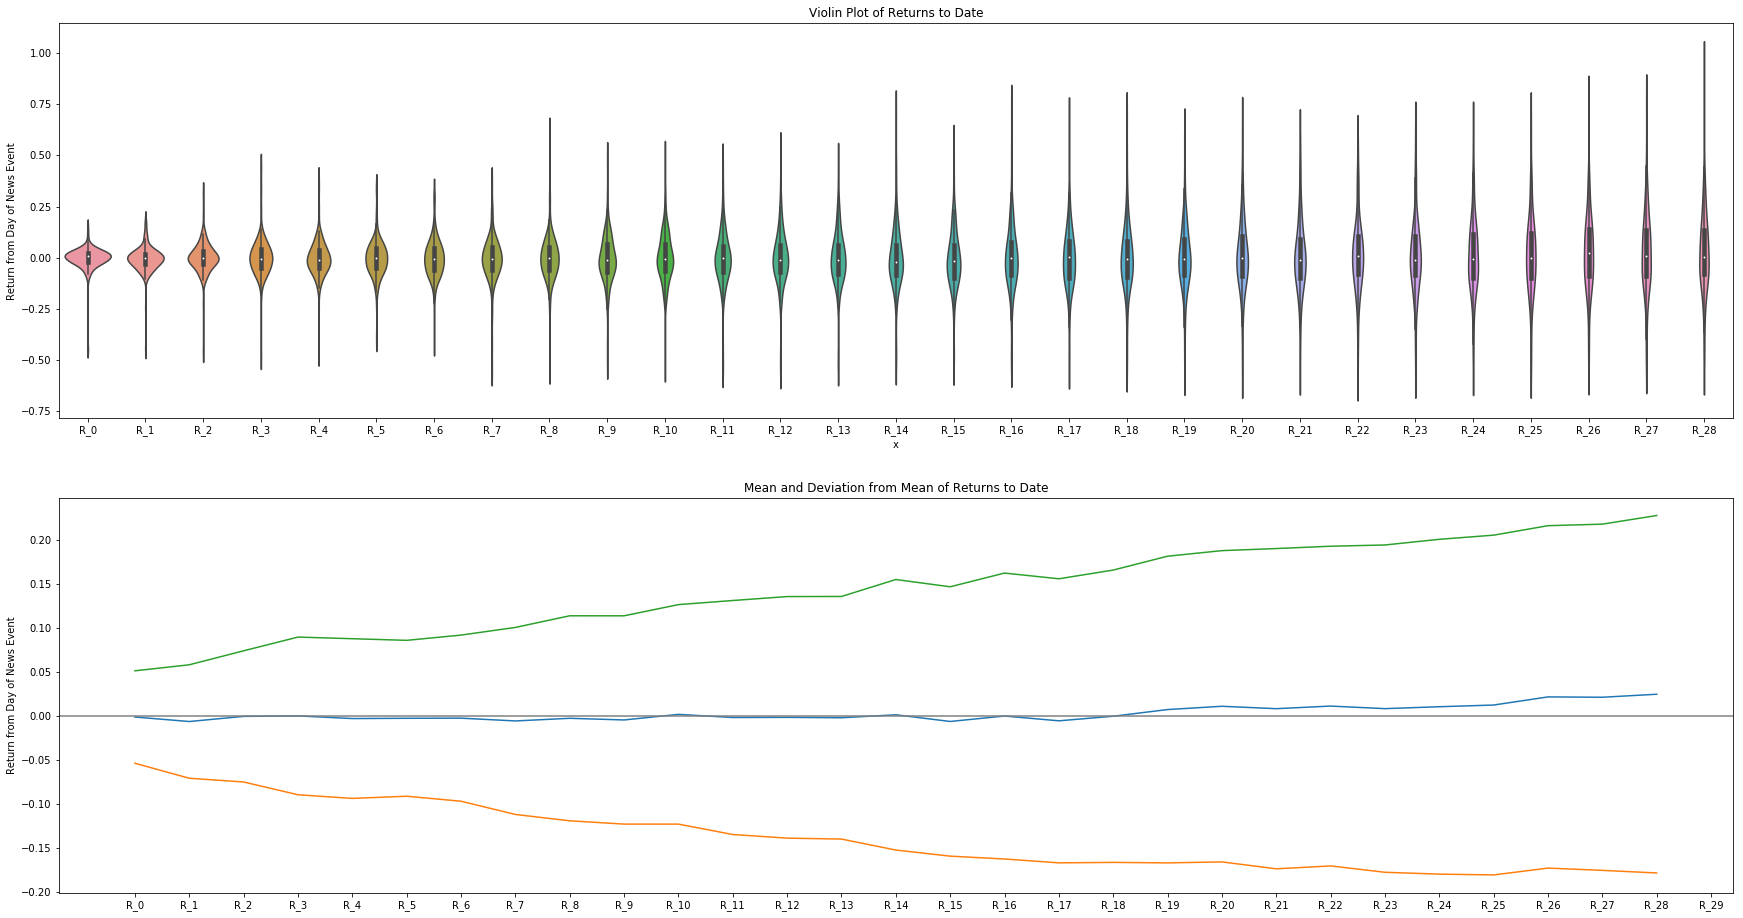

In [171]:
fig, axes = plt.subplots(2, figsize=(30, 16))#, sharex=True)

ax = axes[0]
ax.set_title("Violin Plot of Returns to Date")
sns.violinplot(x=day_vs_value_return_df.x, y=day_vs_value_return_df.y, ax=ax)
ax.set_ylabel("Return from Day of News Event")

ax = axes[1]
ax.set_title("Mean and Deviation from Mean of Returns to Date")
ax.set_ylabel("Return from Day of News Event")
ind_ = ["R_{}".format(i) for i in range(30)] # This needs to be used to keep order...
mu = day_vs_value_return_df.groupby("x").mean().reindex(ind_)
neg_dev = mu - day_vs_value_return_df.groupby("x").std().reindex(ind_)
pos_dev = mu + day_vs_value_return_df.groupby("x").std().reindex(ind_)
_ = ax.plot(mu)
_ = ax.plot(neg_dev)
_ = ax.plot(pos_dev)
_ = ax.axhline(y=0, color="grey")

When using the natural standard deviation we can clearly see that the stock becomes more volatile while the average moves up.

A common practice in finance, especially w.r.t. risk management is to take a look at the positive and negative deviations seperately. This clearly would be a good choice here when looking at the violin plots. The first few days after an event the returns have much more negative bias while the returns further away have a positive bias. (downside and upside deviation)

**Downside deviation:**

$ DD = \sqrt{\frac{\sum{min(0, \mu - r)}^2}{n}} $

**Upside deviation:**

$ UD = \sqrt{\frac{\sum{max(0, \mu - r)}^2}{n}} $

In [145]:
def downside_deviation(values):
    n = len(values)
    mu = np.mean(values)
    
    num = np.sum([(val - mu)**2 for val in values if val - mu <= 0])
    
    return np.sqrt(num / n)

def upside_deviation(values):
    n = len(values)
    mu = np.mean(values)
    
    num = np.sum([(val - mu)**2 for val in values if val - mu > 0])
    
    return np.sqrt(num / n)

downside_deviation(value_stack), upside_deviation(value_stack)

(0.10016718604519091, 0.10844045962315331)

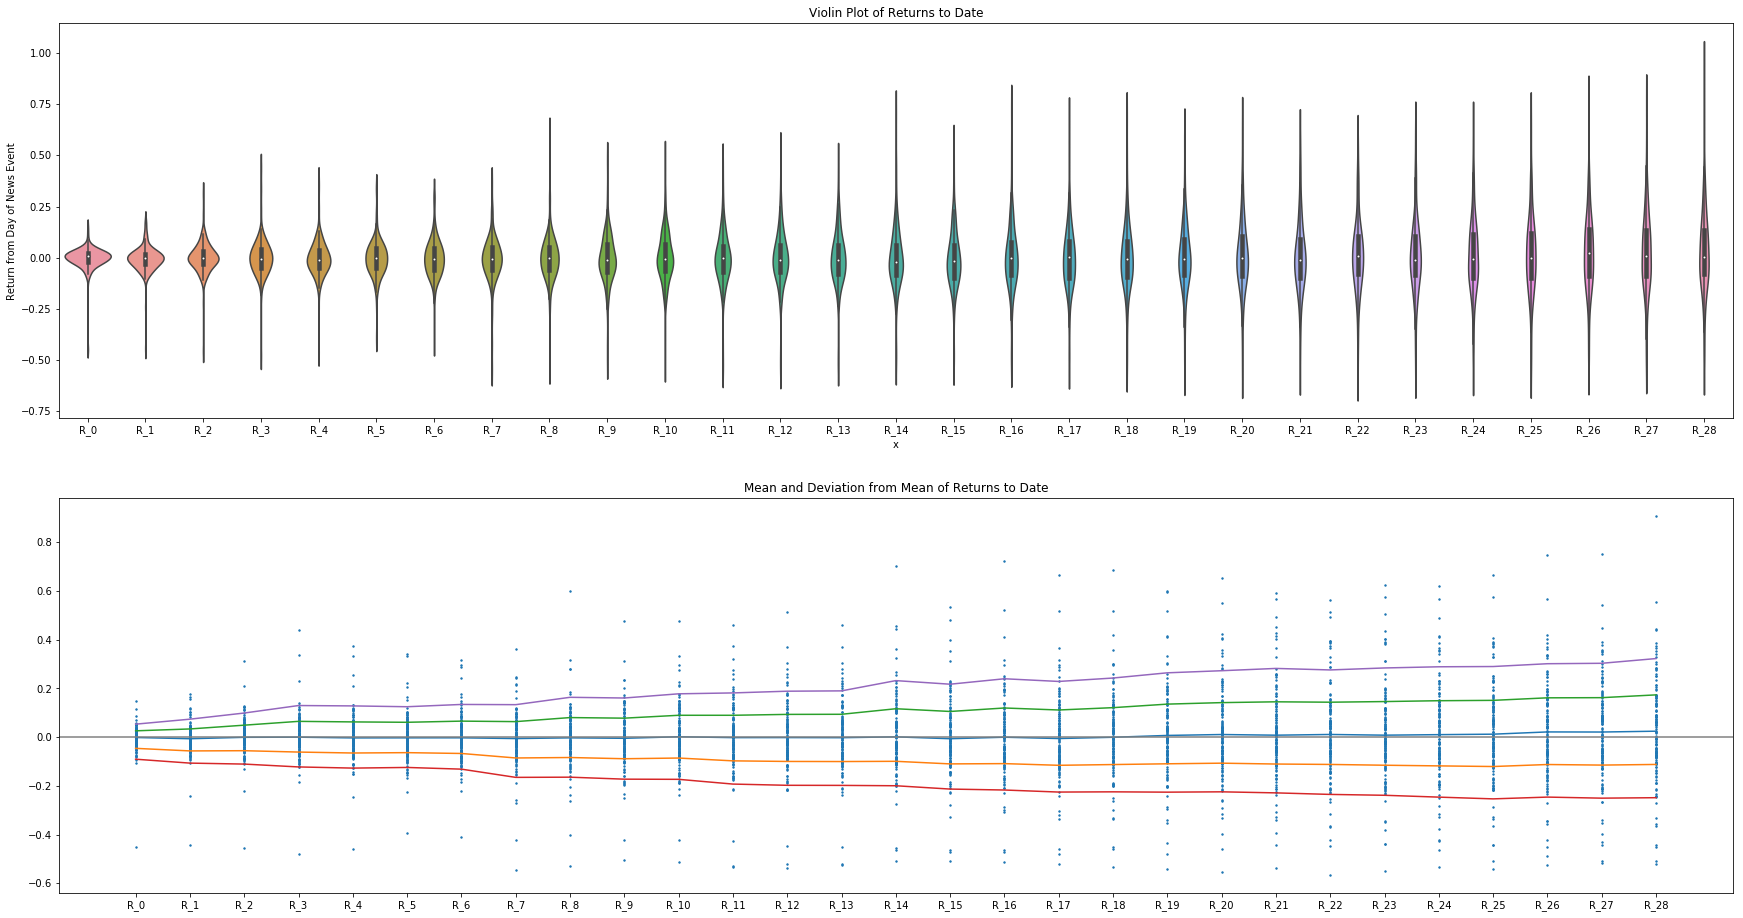

In [166]:
fig, axes = plt.subplots(2, figsize=(30, 16))#, sharex=True)

ax = axes[0]
ax.set_title("Violin Plot of Returns to Date")
sns.violinplot(x=day_vs_value_return_df.x, y=day_vs_value_return_df.y, ax=ax)
ax.set_ylabel("Return from Day of News Event")

ax = axes[1]
ax.set_title("Mean and Deviation from Mean of Returns to Date")

mu = return_window.T.apply(np.mean, axis=1)
neg_dev = mu - return_window.T.apply(downside_deviation, axis=1)
pos_dev = mu + return_window.T.apply(upside_deviation, axis=1)

_ = ax.plot(mu)
_ = ax.plot(neg_dev)
_ = ax.plot(pos_dev)

# Second Deviation
neg_dev = mu - 2 * return_window.T.apply(downside_deviation, axis=1)
pos_dev = mu + 2 * return_window.T.apply(upside_deviation, axis=1)
_ = ax.plot(neg_dev)
_ = ax.plot(pos_dev)

_ = ax.axhline(y=0, color="grey")
_ = ax.scatter(x=day_vs_value_return_df.x, y=day_vs_value_return_df.y, s=2)

Alright, now we have our distributions sort of set up and can look for interesting areas.

**Notes**
* It appears that the bound is quite large making it impractical to have a one size fits all option selling strategy here. It does look like the stocks that drop below, stay below and vice versa for above.
* The deviation naturally grows so buying a strangle could be a possibility as well for some profit. It is known that as volatility increases, so does the price of an option.
* Are there any further keywords from the titles or articles that could further help filter which direction the stock will go?

### Continue in Class (Binary)

Hypothesis, once a stock's price is above 0% return, it will stay above for the 30 day window. The same holds for stock's below 0% return.

To test this I will break the data into 2 set:
1. Events that the first return is above 0
2. Events that the first return is at or below 0

Then will look at the statistics of the days following in a similar manner done as the whole set.

In [176]:
positive_first_return = return_window.loc[return_window.R_0 > 0]
negative_first_return = return_window.loc[return_window.R_0 <= 0]

In [192]:
def violin_plot(df):
    fig, axes = plt.subplots(2, figsize=(30, 16))

    days_vs_value = reshape_for_violin_plot(df)

    ax = axes[0]
    ax.set_title("Violin Plot of Returns to Date")
    sns.violinplot(x=days_vs_value.x, y=days_vs_value.y, ax=ax)
    ax.set_ylabel("Return from Day of News Event")

    ax = axes[1]
    ax.set_title("Mean and Deviation from Mean of Returns to Date")
    ax.set_ylabel("Return from Day of News Event")

    mu = df.T.apply(np.mean, axis=1)
    neg_dev = mu - df.T.apply(downside_deviation, axis=1)
    pos_dev = mu + df.T.apply(upside_deviation, axis=1)

    ax.plot(mu)
    ax.plot(neg_dev)
    ax.plot(pos_dev)
    ax.axhline(y=0, color="grey")
    _ = ax.scatter(x=days_vs_value.x, y=days_vs_value.y, s=2)
    return fig

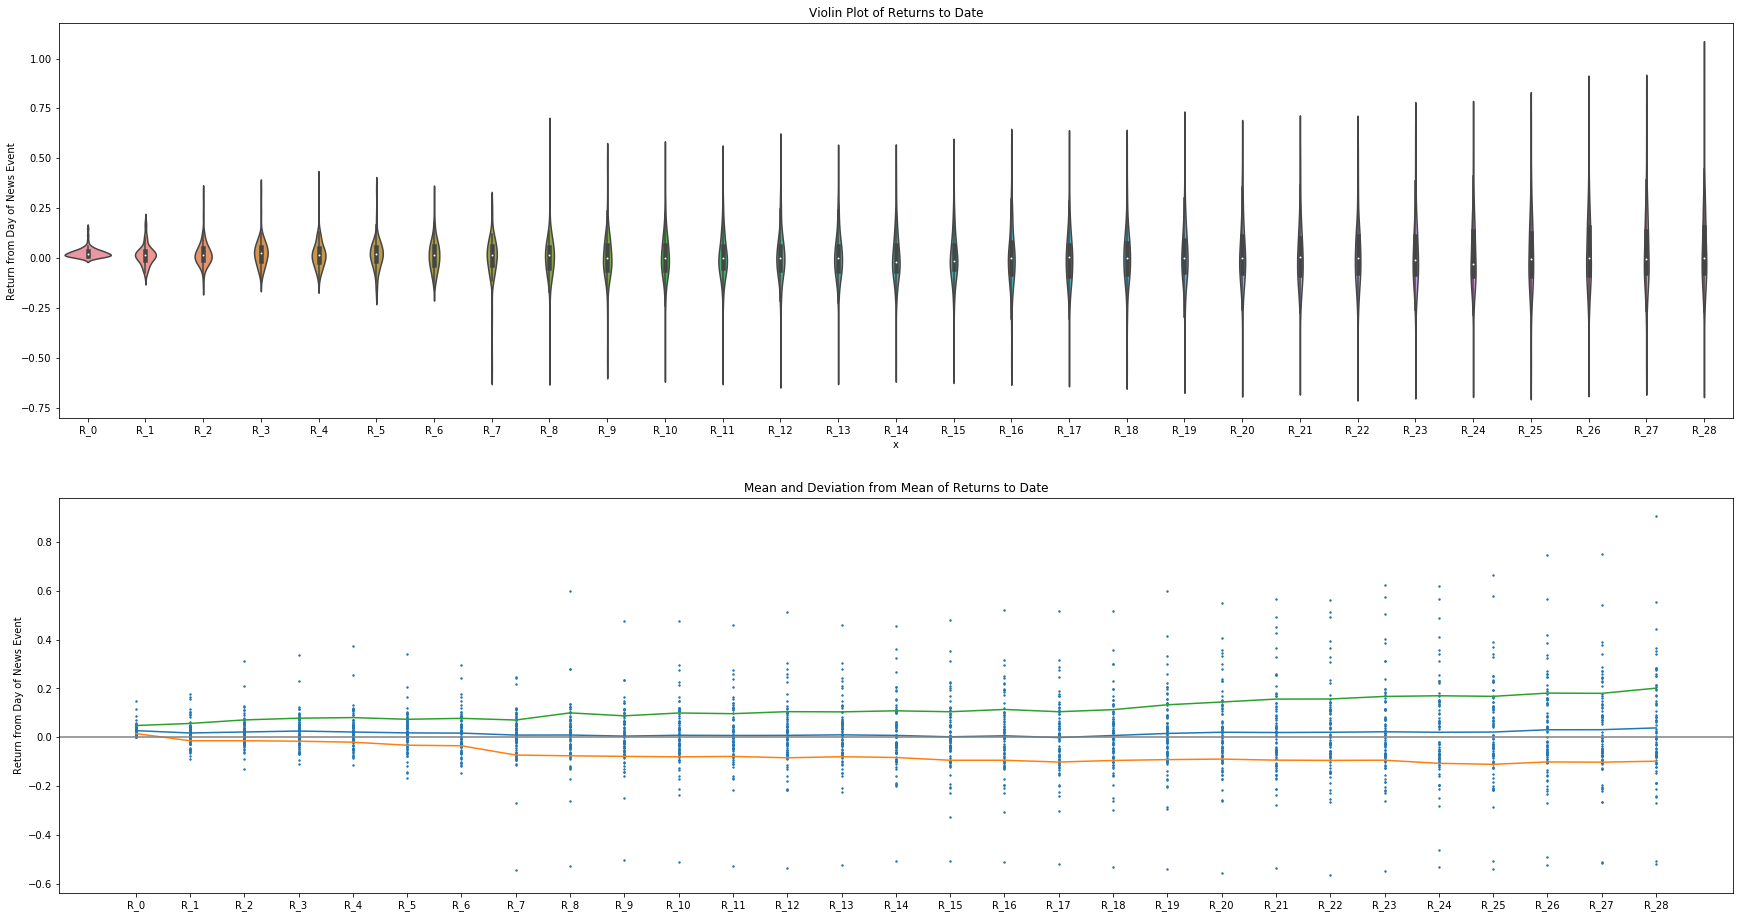

In [193]:
f_pos = violin_plot(positive_first_return)

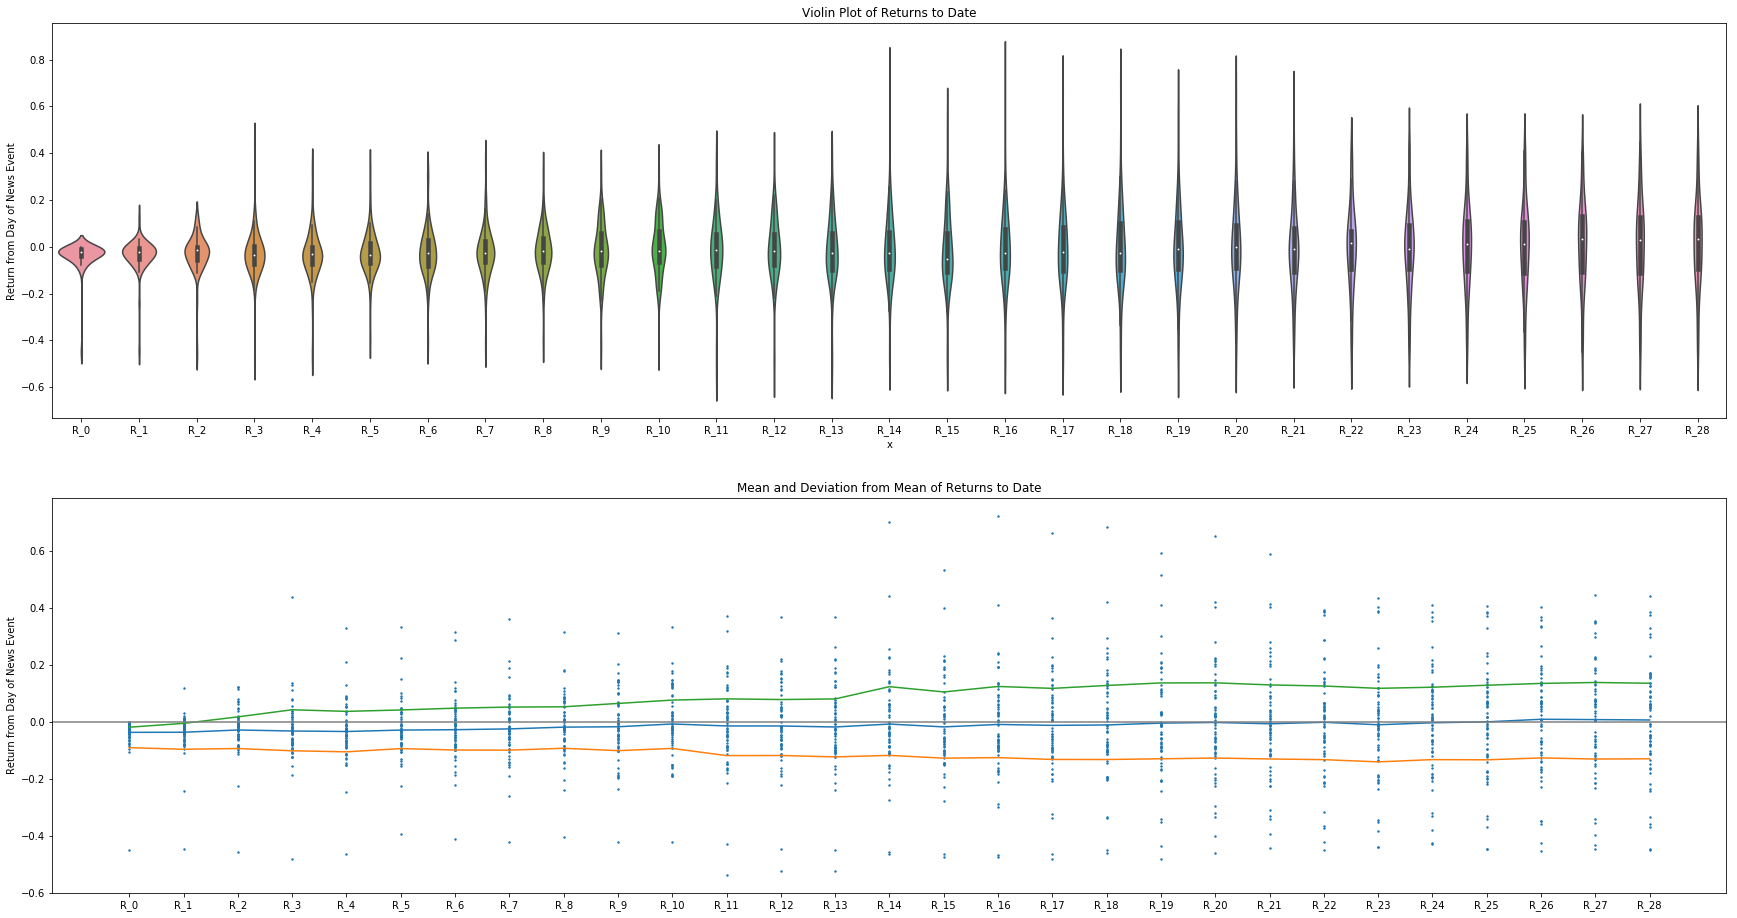

In [194]:
f_neg = violin_plot(negative_first_return)

As can be seen, the effect of starting above or below does have an effect on where the stock prices go.

The effect seems to be short lived really only last 6 days for positive and 3 days for negative.

Overall, it seems plausible to create a profitable options trading strategy around the information here. For stocks that are already positive on the first day, they tend to stay above. Further in this set there are more positive outliers which would give much better returns and push the overall portfolio return much higher as well.

### Keyword Correlation

Now, it would be good to look through the keywords from the article titles and see if there are any keywords that are indicitive of positive or negative results.

The initial look will be very basic and intuitive as we are just take a first look.

Hypothesis:
* Words like positive and negative should be telling of which direction the stock will go. Also w.r.t. exploration there should be other words that may be helpful in determining the direction (and possibly the magnitude)

Collect all of the "important" words (using NLP practices) for a bag of words.

Seperate the events into classes, in this case will use quartiles (this can be changed later on). For each word that has "enough" frequency we want to get as much information as possible about the probability of a company ending in each quartile bracket.

**This will be done in the next notebook**